In [1]:
import geopandas as gpd
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib
import numpy as np
from matplotlib.patches import Patch


# Read in DAta

In [2]:
def read_process_csv_to_gdf(csv):
    temp_df = pd.read_csv(csv)
    temp_df['satellite'] = os.path.basename(csv)[:8]
    temp_df['year'] = int(os.path.basename(csv)[9:13])
    # temp_df = temp_df.loc[temp_df['hydropoly_max']<100]
    temp_df['area_ha'] = temp_df['area']*100/10000 # HA
    temp_df['area_km'] = temp_df['area']*100/(1000*1000) # km2
    # temp_df = temp_df.loc[temp_df['area_ha']<100] # Remove greater than 100 ha
    temp_gdf = gpd.GeoDataFrame(
        temp_df, geometry=gpd.points_from_xy(temp_df.longitude, temp_df.latitude),
        crs='EPSG:4326'
    )
    return temp_gdf

def read_process_region_csv(csv):
    temp_df = pd.read_csv(csv)
    temp_df['satellite'] = os.path.basename(csv)[:8]
    temp_df['year'] = int(os.path.basename(csv)[9:13])

    return temp_df

def sjoin_summarize(points_gdf, poly_gdf, poly_field):
    
    joined_gdf = gpd.sjoin(points_gdf, poly_gdf, predicate='within', how='inner')
    return joined_gdf[['area_ha', poly_field]].groupby(poly_field).agg(['sum', 'count', 'median'])['area_ha']

def sjoin_summarize_nogroup(points_gdf, poly_gdf):
    joined_gdf = gpd.sjoin(points_gdf, poly_gdf, predicate='within', how='inner')
    return joined_gdf[['area_ha']].agg(['sum', 'count', 'median'])

In [3]:
all_csvs = glob.glob('../remove_bad_water/out/sentinel*v6*wgs84*combined_merged.csv')
all_csvs.sort()

# River Basin/Hydrographic Region

In [4]:
basin_gdf = gpd.read_file('./data/macro_RH.shp').to_crs('EPSG:4326')

# State

In [5]:
state_gdf = gpd.read_file('./data/Brazilian_States.shp').to_crs('EPSG:4326')

# Biome

In [6]:
biome_gdf = gpd.read_file('./data/lm_bioma_250.shp').to_crs('EPSG:4326')

# Watershed

In [7]:
# level_name = 'NUNIVOTTO6'
level_name = 'nunivotto6'

In [8]:
dissolved_wgs84_path = './data/watersheds_2017_{}.shp'.format(level_name)

# if not os.path.isfile(dissolved_wgs84_path):
#     watershed_gdf = gpd.read_file('./data/watersheds.shp'
#                                  ).to_crs('EPSG:4326'
#                                          ).dissolve(by=level_name
#                                                    ).clip(state_gdf)
#     watershed_gdf['area_km2'] = watershed_gdf.to_crs('ESRI:102033').area/(1000*1000)
#     watershed_gdf.to_file(dissolved_wgs84_path)
# else:
#     watershed_gdf = gpd.read_file(dissolved_wgs84_path)
if not os.path.isfile(dissolved_wgs84_path):
    watershed_gdf = gpd.read_file('~/Downloads/bho_2017_v_01_05_50k.gpkg', layer='pgh_output.geoft_bho_area_drenagem'
                                    ).to_crs('EPSG:4326'
                                            ).dissolve(by=level_name
                                                    ).clip(state_gdf)
    watershed_gdf['area_km2'] = watershed_gdf.to_crs('ESRI:102033').area/(1000*1000)
    watershed_gdf.to_file(dissolved_wgs84_path)
    watershed_gdf = watershed_gdf.reset_index()
else:
    watershed_gdf = gpd.read_file(dissolved_wgs84_path)

# Run them all by year

In [9]:
for in_csv in all_csvs:
    basin_out_csv = './out/{}'.format(os.path.basename(in_csv).replace('merged.csv', 'basin_stats.csv'))
    state_out_csv = './out/{}'.format(os.path.basename(in_csv).replace('merged.csv', 'state_stats.csv'))
    watershed_out_csv = './out/{}'.format(os.path.basename(in_csv).replace('merged.csv', 'watershed_stats_{}.csv'.format(level_name)))
    biome_out_csv = './out/{}'.format(os.path.basename(in_csv).replace('merged.csv', 'biome_stats.csv'))
    if ((not os.path.isfile(basin_out_csv))
        or (not os.path.isfile(state_out_csv))
        or (not os.path.isfile(watershed_out_csv))):
        res_gdf = read_process_csv_to_gdf(in_csv)
    if (not os.path.isfile(basin_out_csv)):
        basin_results = sjoin_summarize(res_gdf, basin_gdf, 'nm_macroRH')
        basin_results.to_csv(basin_out_csv)
    if (not os.path.isfile(state_out_csv)):
        state_results = sjoin_summarize(res_gdf, state_gdf, 'UF_05')
        state_results.to_csv(state_out_csv)
    if (not os.path.isfile(watershed_out_csv)):
        watershed_results = sjoin_summarize(res_gdf, watershed_gdf, level_name)
        watershed_results.to_csv(watershed_out_csv)
    if (not os.path.isfile(biome_out_csv)):
        biome_results = sjoin_summarize(res_gdf, biome_gdf, 'CD_Bioma')
        biome_results.to_csv(biome_out_csv)
    print(os.path.basename(in_csv), "Done")

sentinel_2021_v6_wgs84_combined_merged.csv Done


 # Make some figures

### Basin

In [10]:
# Map
basin_csvs = glob.glob('./out/sentinel*v6*basin*.csv')
basin_csvs.sort()
basin_list = [read_process_region_csv(csv) for csv in basin_csvs]
basin_df = pd.concat(basin_list).set_index('year')
basin_df = basin_df.sort_index()
# 2021 only
basin_df = basin_df.loc[2021]
basin_df = basin_df.drop(columns='satellite')
basin_gdf['area_km2'] = basin_gdf.to_crs('ESRI:102033').area/(1000*1000)
basin_gdf_merged = basin_gdf.copy()
for y in basin_df.index.unique():
    basin_stats_to_merge = basin_df.loc[y].set_index('nm_macroRH').add_suffix('_{}'.format(y))
    basin_gdf_merged = basin_gdf_merged.merge(basin_stats_to_merge, left_on='nm_macroRH', right_index=True)
basin_gdf_merged = basin_gdf_merged.fillna(0)
# basin_gdf_merged['count_diff']  = basin_gdf_merged['count_2021'] - basin_gdf_merged['count_2017']
# for suffix in ['2017','2021','diff']:
for suffix in ['2021']:
    basin_gdf_merged['density_{}'.format(suffix)] = (basin_gdf_merged['count_{}'.format(suffix)]
                                                     /basin_gdf_merged['area_km2'])


## State

In [11]:
# Map
state_csvs = glob.glob('./out/sentinel*v6*state*.csv')
state_csvs.sort()
state_list = [read_process_region_csv(csv) for csv in state_csvs]
state_df = pd.concat(state_list).set_index('year')
state_df = state_df.sort_index()
# 2021 only
state_df = state_df.loc[2021]
state_df = state_df.drop(columns='satellite')
state_gdf['area_km2'] = state_gdf.to_crs('ESRI:102033').area/(1000*1000)
state_gdf_merged = state_gdf.copy()
for y in state_df.index.unique():
    state_stats_to_merge = state_df.loc[y].set_index('UF_05').add_suffix('_{}'.format(y))
    state_gdf_merged = state_gdf_merged.merge(state_stats_to_merge, left_on='UF_05', right_index=True)
state_gdf_merged = state_gdf_merged.fillna(0)
# state_gdf_merged['count_diff']  = state_gdf_merged['count_2021'] - state_gdf_merged['count_2017']
# for suffix in ['2017','2021','diff']:
for suffix in ['2021']:
    state_gdf_merged['density_{}'.format(suffix)] = (state_gdf_merged['count_{}'.format(suffix)]
                                                     /state_gdf_merged['area_km2'])


### Watershed

In [12]:
   # Map
watershed_csvs = glob.glob('./out/sentinel*watershed*{}.csv'.format(level_name))
watershed_csvs.sort()
watershed_list = [read_process_region_csv(csv) for csv in watershed_csvs]
watershed_df = pd.concat(watershed_list).set_index('year')
watershed_df = watershed_df.sort_index()
# 2021 only
watershed_df = watershed_df.loc[2021]
watershed_df = watershed_df.drop(columns='satellite')
watershed_gdf[level_name] = watershed_gdf[level_name].astype(int)
# watershed_gdf.index = watershed_gdf.index.astype(int)
watershed_gdf_merged = watershed_gdf.copy()
for y in watershed_df.index.unique():
    watershed_stats_to_merge = watershed_df.loc[y].set_index(level_name).add_suffix('_{}'.format(y))
    watershed_gdf_merged = watershed_gdf_merged.merge(watershed_stats_to_merge,
                                                      left_on=level_name, right_index=True,
                                                     how='left')
watershed_gdf_merged = watershed_gdf_merged.fillna(0)
# watershed_gdf_merged['count_diff']  = watershed_gdf_merged['count_2021'] - watershed_gdf_merged['count_2017']
# for suffix in ['2017','2021','diff']:
for suffix in ['2021']:
    watershed_gdf_merged['density_{}'.format(suffix)] = (watershed_gdf_merged['count_{}'.format(suffix)]
                                                     /watershed_gdf_merged['area_km2'])



### Biome

In [13]:
   # Map
biome_csvs = glob.glob('./out/sentinel*biome*.csv')
biome_csvs.sort()
biome_list = [read_process_region_csv(csv) for csv in biome_csvs]
biome_df = pd.concat(biome_list).set_index('year')
biome_df = biome_df.sort_index()
# 2021 only
biome_df = biome_df.loc[2021]
biome_df = biome_df.drop(columns='satellite')
biome_gdf['CD_Bioma'] = biome_gdf['CD_Bioma'].astype(int)
biome_gdf['area_km2'] = biome_gdf.to_crs('ESRI:102033').area/(1000*1000)
# biome_gdf.index = biome_gdf.index.astype(int)
biome_gdf_merged = biome_gdf.copy()
for y in biome_df.index.unique():
    biome_stats_to_merge = biome_df.loc[y].set_index('CD_Bioma').add_suffix('_{}'.format(y))
    biome_gdf_merged = biome_gdf_merged.merge(biome_stats_to_merge,
                                                      left_on='CD_Bioma', right_index=True,
                                                     how='left')
biome_gdf_merged = biome_gdf_merged.fillna(0)
# watershed_gdf_merged['count_diff']  = watershed_gdf_merged['count_2021'] - watershed_gdf_merged['count_2017']
# for suffix in ['2017','2021','diff']:
for suffix in ['2021']:
    biome_gdf_merged['density_{}'.format(suffix)] = (biome_gdf_merged['count_{}'.format(suffix)]
                                                     /biome_gdf_merged['area_km2'])



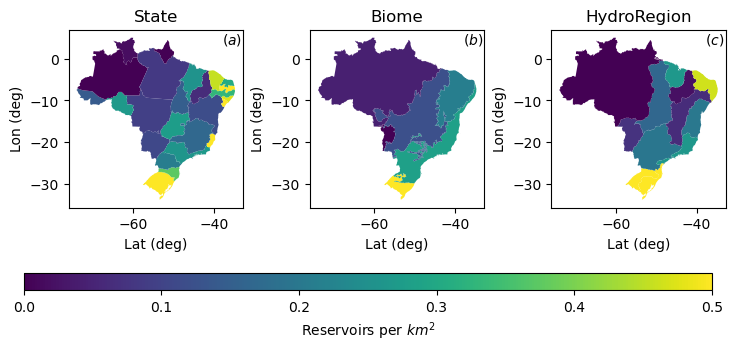

In [14]:

fig, axs = plt.subplots(1,3, figsize=(7.24,3.5), constrained_layout=True)

state_gdf_merged.clip([-74, -34, -34, 5]).plot(column='density_2021',
              ax=axs[0], legend=False, vmax=0.5)
biome_gdf_merged.clip([-74, -34, -34, 5]).plot(column='density_2021',
              ax=axs[1], legend=False, vmax=0.5)
basin_gdf_merged.clip([-74, -34, -34, 5]).plot(column='density_2021',
              ax=axs[2], legend=False, vmax=0.5)

# watershed_gdf_merged.plot(column='density_2021',
#               ax=axs[1,1], legend=True,vmax=1.0)
axs[0].set_title('State')
axs[1].set_title('Biome')
axs[2].set_title('HydroRegion')

for ax in axs.flatten():
    ax.set_xlabel('Lat (deg)')
    ax.set_ylabel('Lon (deg)')

# Define the colormap and normalization
cmap = plt.cm.viridis  # Choose the colormap
norm = Normalize(vmin=0, vmax=0.5)  # Set the range from 0 to 0.5

# Create a ScalarMappable and add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the ScalarMappable
cbar = fig.colorbar(sm, cax=fig.add_axes([0.025, 0.01, 0.95, 0.05]), orientation='horizontal')
cbar.set_label('Reservoirs per $km^2$')
# Add annotations
for i, label in enumerate(['$(a)$', '$(b)$', '$(c)$']):
    axs[i].annotate(
            label,
            xy=(1, 1), xycoords='axes fraction',
            xytext=(-1.5, -1.3), textcoords='offset fontsize',
            fontsize=10, verticalalignment='bottom', fontfamily='serif')
plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist.svg', dpi=300)
# plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist.eps', dpi=300)
plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist.jpg', dpi=300,
            pil_kwargs={'quality':95},
            bbox_inches='tight')
# fig.tight_layout()

In [15]:
watershed_gdf_merged['density_2021'].max()

6.997059801979103

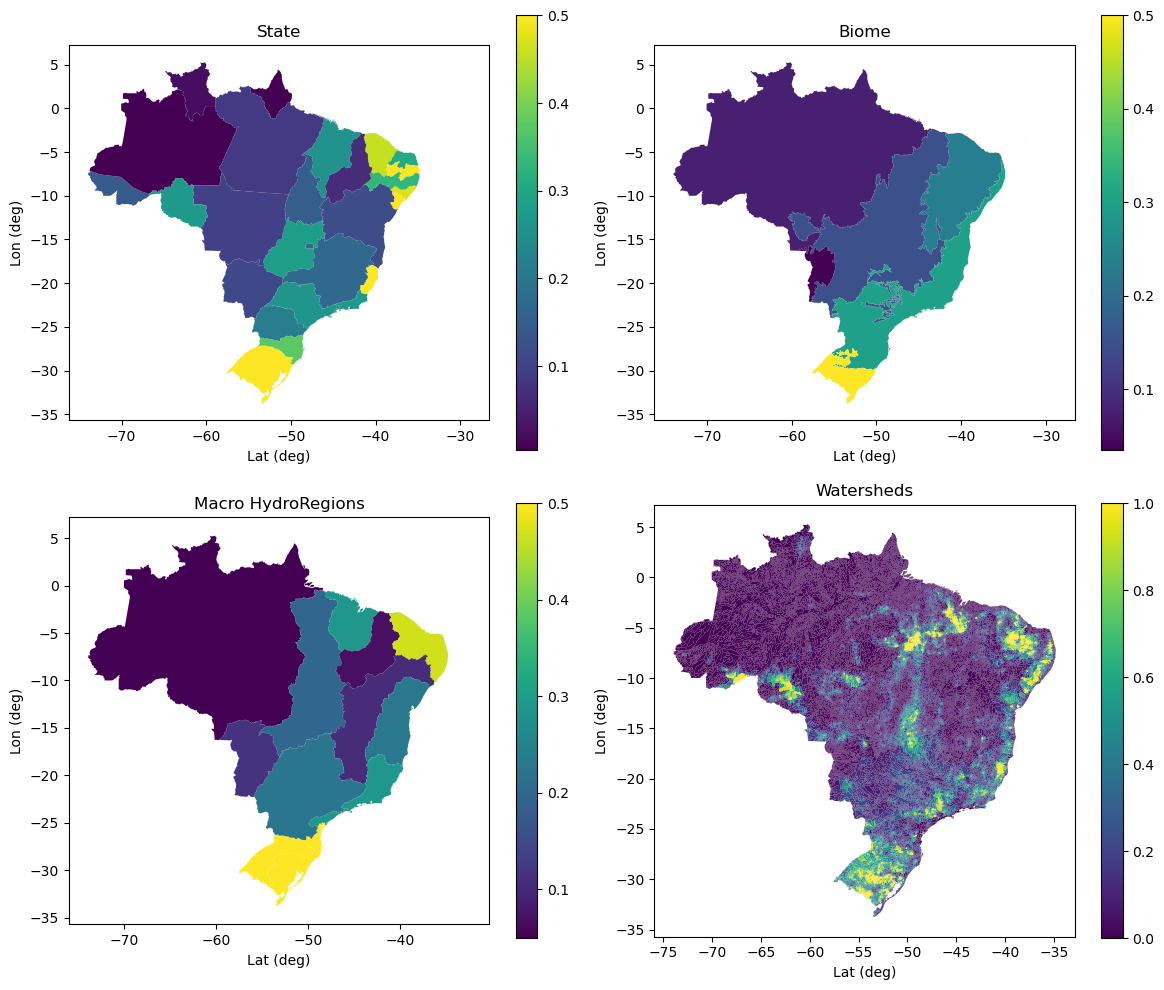

In [16]:

fig, axs = plt.subplots(2,2, figsize=(12,10))

state_gdf_merged.plot(column='density_2021',
              ax=axs[0,0], legend=True, vmax=0.5)

biome_gdf_merged.plot(column='density_2021',
              ax=axs[0,1], legend=True, vmax=0.5)
basin_gdf_merged.plot(column='density_2021',
              ax=axs[1,0], legend=True, vmax=0.5)

watershed_gdf_merged.plot(column='density_2021',
              ax=axs[1,1], legend=True,vmax=1.0, linewidth=0.0, edgecolor=None)
axs[0,0].set_title('State')
axs[0,1].set_title('Biome')
axs[1,0].set_title('Macro HydroRegions')
axs[1,1].set_title('Watersheds')

for ax in axs.flatten():
    ax.set_xlabel('Lat (deg)')
    ax.set_ylabel('Lon (deg)')

fig.tight_layout()

# Misc Others for Comparisons

In [17]:
res_gdf = read_process_csv_to_gdf('../remove_bad_water/out/sentinel_2021_v6_wgs84_combined_merged.csv')

In [18]:
res_gdf = res_gdf.loc[res_gdf['area_ha']<100]

### Upper Xingu

In [19]:
xingu_shp_path = '../../../../../analysis/data/misc/general_borders/UpperXingu.shp'
xingu_gdf = gpd.read_file(xingu_shp_path).to_crs('EPSG:4326')
xingu_stats = sjoin_summarize_nogroup(res_gdf, xingu_gdf)
print(xingu_stats)

         area_ha
sum     13042.19
count   11149.00
median      0.30


### Sorrisio Muni

In [20]:
sorriso_shp_path = '../../../../../analysis/data/misc/municipal_units/sorriso_only.shp'
sorriso_gdf = gpd.read_file(sorriso_shp_path).to_crs('EPSG:4326')
sorriso_stats = sjoin_summarize_nogroup(res_gdf, sorriso_gdf)
print(sorriso_stats)

        area_ha
sum     1565.03
count    764.00
median     0.40


### Mato Grosso Only

In [21]:
state_gdf = gpd.read_file('./data/Brazilian_States.shp').to_crs('EPSG:4326')
mt_gdf = state_gdf.loc[state_gdf['UF_05']=='MT']
mt_stats = sjoin_summarize_nogroup(res_gdf, mt_gdf)
# mt_stats = sjoin_summarize(res_gdf, state_gdf, 'UF_05')# 
print(mt_stats)

         area_ha
sum     59532.59
count   89275.00
median      0.18


### Amazonia Only

In [22]:
biome_gdf = gpd.read_file('./data/lm_bioma_250.shp').to_crs('EPSG:4326')
amz_gdf = biome_gdf.loc[biome_gdf['CD_Bioma']==1]
amz_stats = sjoin_summarize_nogroup(res_gdf, amz_gdf)
print(amz_stats)

          area_ha
sum     136374.84
count   317207.00
median       0.16


# Global Dam Watch Calcs

In [23]:
gdw_df = gpd.read_file('../../../../reservoir-id-cnn/reservoir-id-cnn/analysis/other_dams/gdw/GDW_v1_0_shp/GDW_barriers_v1_0.shp')

In [24]:
gdw_df.loc[gdw_df['AREA_POLY']>0]['AREA_POLY'].max()

66866.692

In [25]:
gdw_brazil = gdw_df.loc[gdw_df.COUNTRY=='Brazil']
gdw_brazil = gdw_brazil.loc[gdw_brazil.AREA_POLY>0]

In [26]:
gdw_brazil['AREA_POLY'].median()

0.234

In [27]:
(gdw_brazil['AREA_POLY']<0.01).sum()

151

In [28]:

gdw_brazil.loc[gdw_brazil['AREA_POLY'] <1, 'AREA_POLY'].sum()

1121.5539999999999

In [29]:

gdw_brazil.sort_values('AREA_POLY', ascending=False)['AREA_POLY'].iloc[:3].sum()

7238.0599999999995

In [30]:

gdw_brazil['AREA_POLY'].argmax()

2

In [31]:
gdw_brazil.sort_values('AREA_POLY',ascending=False ).iloc[:5]['AREA_POLY'].sum()

9514.043

# Compare with ANA

In [32]:

ana_gdf = gpd.read_file('../compare_other_methods/data/ana/Massas_d_Agua.shp')
ana_gdf = ana_gdf.loc[ana_gdf['detipomass']=='Artificial']
ana_gdf = ana_gdf.loc[ana_gdf['nuareakm2']<1]


In [33]:

biome_gdf = gpd.read_file('./data/lm_bioma_250.shp').to_crs('EPSG:3857')

In [34]:
ana_gdf['geometry'] = ana_gdf['geometry'].centroid

In [35]:
joined_gdf = gpd.sjoin(ana_gdf, biome_gdf, predicate='within', how='inner')
joined_gdf['area_ha'] = joined_gdf['nuareakm2']*100
ana_gdf_biome = joined_gdf[['area_ha', 'Bioma']].groupby('Bioma').agg(['sum', 'count', 'median'])['area_ha']

In [36]:

biome_gdf = gpd.read_file('../regions/data/lm_bioma_250.shp').to_crs('EPSG:4326')
full_df = pd.read_csv('../remove_bad_water/data/sentinel_2021_v6_cleaned.csv')
full_gdf = gpd.GeoDataFrame(
    full_df, geometry=gpd.points_from_xy(full_df.longitude, full_df.latitude),
    crs='EPSG:4326'
)
joined_gdf = gpd.sjoin(full_gdf, biome_gdf, predicate='within', how='inner')
count_area_df = joined_gdf[['Bioma','area_ha']].groupby(['Bioma']).agg(['sum','count', 'median'])
# count_df = joined_gdf.groupby(['Bioma']).count()
# count_df_complete = count_df[['CD_Bioma']].rename(columns={'CD_Bioma':'Count'})
# count_df_complete = count_df[['CD_Bioma']].rename(columns={'':'Count'})

In [37]:
combined_df = count_area_df['area_ha'].merge(ana_gdf_biome[['count', 'sum']], left_index=True, right_index=True, suffixes=['_our', '_ana'])

In [38]:
bar_colordict = {
    'Amazônia': '#b3c4b9',
    'Caatinga': '#adc0cc',
    'Cerrado': '#e0bc86',
    'Mata Atlântica': '#898b9e',
    'Pampa': '#bdcc99',
    'Pantanal': '#ab9c97'
}
bar_grayscaledict = {
    'Amazônia': '#666666',
    'Caatinga': '#4d4d4d',
    'Cerrado': '#d9d9d9',
    'Mata Atlântica': '#b3b3b3',
    'Pampa': '#8c8c8c',
    'Pantanal': '#1a1a1a'
}
hatch_dict = {
    'our': None,
    'ana': '///',
}
alpha_dict = {
    'our': 1.0,
    'ana': 0.5,
}

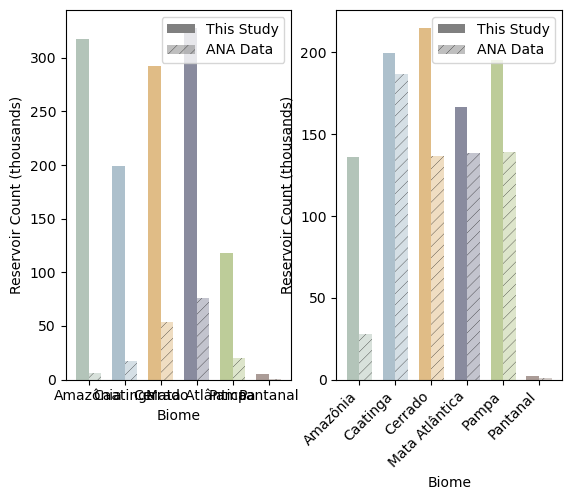

In [39]:
matplotlib.rcParams['hatch.linewidth'] = 0.2 
labels=combined_df.index
x0 = np.arange(len(labels))  # create an array of values for the ticks that can perform arithmetic with width (w)

fig, axs = plt.subplots(1,2)

# Count
ax=axs[0]
# build the plots
groups = ['count_our','count_ana']
stacks = len(groups)  # how many stacks in each group for a tick location

# set the width
w = 0.35

# this needs to be adjusted based on the number of stacks; each location needs to be split into the proper number of locations
x1 = [x0 - w/stacks, x0 + w/stacks]

for i, label in enumerate(labels):
    for x, dataset in zip(x1, groups):
        bar_height = combined_df.loc[label, dataset]/1000
        if dataset == 'sum_our':
            leg_label=label
        else:
            leg_label=None
        ax.bar(x=x[i], height=bar_height, width=w,
                hatch=hatch_dict[dataset[-3:]], 
                color=bar_colordict[label],
                alpha=alpha_dict[dataset[-3:]],
                label=leg_label)
leg_patches = [
    Patch(facecolor='grey',alpha=1.0, label='This Study'),
    Patch(facecolor='grey',hatch='///', alpha=0.5, label='ANA Data')
]
ax.set_xticks(np.arange(0,6))
ax.set_xticklabels(labels)
ax.set_ylabel('Reservoir Count (thousands)')
ax.set_xlabel('Biome')
plt.xticks(rotation=45, ha='right')
ax.legend(handles=leg_patches)

# Total Area
ax=axs[1]
# build the plots
groups = ['sum_our','sum_ana']
stacks = len(groups)  # how many stacks in each group for a tick location

# set the width
w = 0.35

# this needs to be adjusted based on the number of stacks; each location needs to be split into the proper number of locations
x1 = [x0 - w/stacks, x0 + w/stacks]

for i, label in enumerate(labels):
    for x, dataset in zip(x1, groups):
        bar_height = combined_df.loc[label, dataset]/1000
        if dataset == 'sum_our':
            leg_label=label
        else:
            leg_label=None
        ax.bar(x=x[i], height=bar_height, width=w,
                hatch=hatch_dict[dataset[-3:]], 
                color=bar_colordict[label],
                alpha=alpha_dict[dataset[-3:]],
                label=leg_label)
leg_patches = [
    Patch(facecolor='grey',alpha=1.0, label='This Study'),
    Patch(facecolor='grey',hatch='///', alpha=0.5, label='ANA Data')
]
ax.set_xticks(np.arange(0,6))
ax.set_xticklabels(labels)
ax.set_ylabel('Reservoir Count (thousands)')
ax.set_xlabel('Biome')
plt.xticks(rotation=45, ha='right')
ax.legend(handles=leg_patches)


In [40]:

   # Map
biome_csvs = glob.glob('./out/sentinel*biome*.csv')
biome_csvs.sort()
biome_list = [read_process_region_csv(csv) for csv in biome_csvs]
biome_df = pd.concat(biome_list).set_index('year')
biome_df = biome_df.sort_index()
# 2021 only
biome_df = biome_df.loc[2021]
biome_df = biome_df.drop(columns='satellite')
biome_gdf['CD_Bioma'] = biome_gdf['CD_Bioma'].astype(int)
biome_gdf['area_km2'] = biome_gdf.to_crs('ESRI:102033').area/(1000*1000)
# biome_gdf.index = biome_gdf.index.astype(int)
biome_gdf_merged = biome_gdf.copy()
for y in biome_df.index.unique():
    biome_stats_to_merge = biome_df.loc[y].set_index('CD_Bioma').add_suffix('_{}'.format(y))
    biome_gdf_merged = biome_gdf_merged.merge(biome_stats_to_merge,
                                                      left_on='CD_Bioma', right_index=True,
                                                     how='left')
biome_gdf_merged = biome_gdf_merged.fillna(0)
# watershed_gdf_merged['count_diff']  = watershed_gdf_merged['count_2021'] - watershed_gdf_merged['count_2017']
# for suffix in ['2017','2021','diff']:
for suffix in ['2021']:
    biome_gdf_merged['density_{}'.format(suffix)] = (biome_gdf_merged['count_{}'.format(suffix)]
                                                     /biome_gdf_merged['area_km2'])


biome_rename_dict = {
    'Amazônia': 'Amazon',
    'Caatinga': 'Caatinga',
    'Cerrado': 'Cerrado',
    'Pampa': 'Pampa',
    'Mata Atlântica': 'Mata\nAtlântica',
    'Pantanal': 'Pantanal'
}
biome_gdf_merged['Bioma'] = biome_gdf_merged['Bioma'].map(biome_rename_dict)


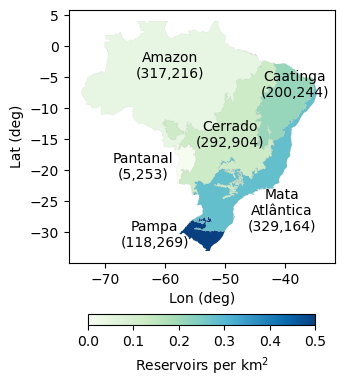

In [41]:

fig, ax = plt.subplots(1,1, figsize=(3.75,3.75), constrained_layout=True)

biome_gdf_merged.clip([-74, -33, -33, 4]).plot(column='density_2021',
              ax=ax, cmap='GnBu', legend=False, vmax=0.5,
              edgecolor='grey', linewidth=0.025)

ha_dict = {
    'Amazon': 'center',
    'Caatinga': 'center',
    'Cerrado': 'center',
    'Mata\nAtlântica': 'center',
    'Pampa': 'center',
    'Pantanal': 'center'
}
text_colordict = {
    'Amazon': 'black',
    'Caatinga': 'black',
    'Cerrado': 'black',
    'Mata\nAtlântica': 'black',
    'Pampa': 'black',
    'Pantanal': 'black'
}
offset_dict = {
    'Amazon': 0,
    'Caatinga': np.array([2,1]),
    'Cerrado': np.array([0, -2]),
    'Mata\nAtlântica': np.array([6.25, -8]),
    'Pampa': np.array([-8, -2]),
    'Pantanal': np.array([-7, -3])
}



biome_gdf_merged.apply(lambda x: ax.annotate(text='{}\n({:,})'.format(x['Bioma'], x['count_2021']), 
                                                 xy=np.array(x.geometry.centroid.coords[0]) + offset_dict[x['Bioma']],
                                                 ha=ha_dict[x['Bioma']],
                                                 color=text_colordict[x['Bioma']]), axis=1)

ax.set_xlabel('Lon (deg)')
ax.set_ylabel('Lat (deg)')

# # Define the colormap and normalization
cmap = plt.cm.GnBu  # Choose the colormap
norm = Normalize(vmin=0, vmax=0.5)  # Set the range from 0 to 0.5

# Create a ScalarMappable and add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the ScalarMappable
cbar = fig.colorbar(sm, orientation='horizontal', ax=ax,
                    fraction=0.045, pad=0.03)#cax=fig.add_axes([0.2, 0.001, 0.6, 0.03]), orientation='horizontal')
cbar.set_label('Reservoirs per km$^2$')
# plt.colorbar(ax.collections[0], orientation="horizontal")
plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist_biome.svg', dpi=300)
plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist_biome.jpg', dpi=300,
            pil_kwargs={'quality':95},
            bbox_inches='tight')
# plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist_vs_ana_lowquality.jpg', dpi=150,
#             bbox_inches='tight')

In [42]:
print(watershed_gdf_merged['nunivotto6'].unique().shape)
(watershed_gdf_merged['count_2021']>0).sum()

(44295,)


26248

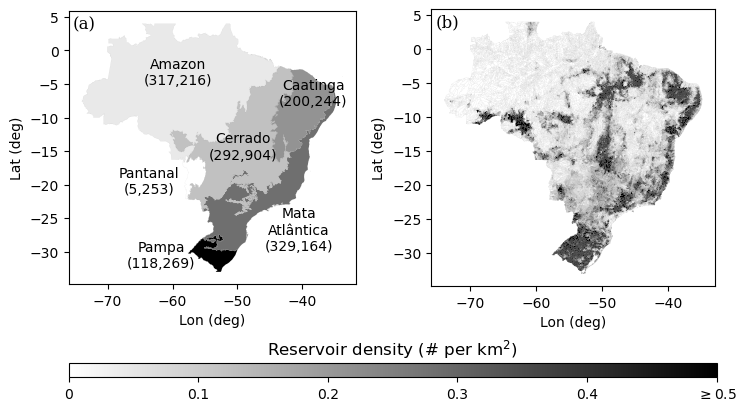

In [43]:

axes_height_ratios=[1, 0.05]
fig, axs = plt.subplots(2,2, figsize=(7.35,4.00), constrained_layout=True,
                       gridspec_kw={"height_ratios":axes_height_ratios})

ax=axs[0, 0]
biome_gdf_merged.clip([-74, -33, -33, 4]).plot(column='density_2021',
              ax=ax, cmap='gist_yarg', legend=False, vmax=0.5,
              edgecolor='grey', linewidth=0.025)

ha_dict = {
    'Amazon': 'center',
    'Caatinga': 'center',
    'Cerrado': 'center',
    'Mata\nAtlântica': 'center',
    'Pampa': 'center',
    'Pantanal': 'center'
}
text_colordict = {
    'Amazon': 'black',
    'Caatinga': 'black',
    'Cerrado': 'black',
    'Mata\nAtlântica': 'black',
    'Pampa': 'black',
    'Pantanal': 'black'
}
offset_dict = {
    'Amazon': 0,
    'Caatinga': np.array([2,1]),
    'Cerrado': np.array([0, -2]),
    'Mata\nAtlântica': np.array([6.25, -8]),
    'Pampa': np.array([-8, -2]),
    'Pantanal': np.array([-7, -3])
}



biome_gdf_merged.apply(lambda x: ax.annotate(text='{}\n({:,})'.format(x['Bioma'], x['count_2021']), 
                                                 xy=np.array(x.geometry.centroid.coords[0]) + offset_dict[x['Bioma']],
                                                 ha=ha_dict[x['Bioma']],
                                                 color=text_colordict[x['Bioma']]), axis=1)

ax.set_xlabel('Lon (deg)')
ax.set_ylabel('Lat (deg)')



# Watersheds
ax=axs[0, 1]
watershed_gdf_merged.clip([-74, -33, -33, 4]).plot(column='density_2021',
              ax=ax, cmap='gist_yarg', legend=False, vmax=0.5,
              edgecolor='grey', linewidth=0.02)
ax.set_xlabel('Lon (deg)')
ax.set_ylabel('Lat (deg)')

# Combined colorbar
# Define the colormap and normalization
cmap = plt.cm.gist_yarg  # Choose the colormap
norm = Normalize(vmin=0, vmax=0.5)  # Set the rtnge from 0 to 0.5
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the ScalarMappable
gs = axs[1, 0].get_gridspec()
for ax in axs[-1]:
    ax.remove()
axbig = fig.add_subplot(gs[-1, :])
axbig.set_title('Reservoir density (# per km$^2)$')
cb = fig.colorbar(sm, cax=axbig, orientation='horizontal',
                  ticks=np.arange(0, 0.51, 0.1))
cb.ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, '$\geq$0.5'])

for i, label in enumerate(['(a)', '(b)']):
    axs[0].flatten()[i].annotate(
            label,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(0.25, -1.3), textcoords='offset fontsize',
            fontsize=12, verticalalignment='bottom', fontfamily='serif')


# plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist_biome_watershed.svg', dpi=300)
# plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist_biome_watershed.jpg', dpi=300,
#             pil_kwargs={'quality':95},
#             bbox_inches='tight')
# plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist_vs_ana_lowquality.jpg', dpi=150,
#             bbox_inches='tight')

In [44]:


# fig, axs = plt.subplots(1,2, figsize=(7.24,3.5), constrained_layout=True)

# biome_gdf_merged.clip([-74, -33, -33, 4]).plot(column='density_2021',
#               ax=axs[0], cmap='GnBu', legend=False, vmax=0.5,
#               edgecolor='grey', linewidth=0.025)

# ha_dict = {
#     'Amazon': 'center',
#     'Caatinga': 'center',
#     'Cerrado': 'center',
#     'Mata\nAtlântica': 'center',
#     'Pampa': 'center',
#     'Pantanal': 'center'
# }
# text_colordict = {
#     'Amazon': 'black',
#     'Caatinga': 'black',
#     'Cerrado': 'black',
#     'Mata\nAtlântica': 'black',
#     'Pampa': 'black',
#     'Pantanal': 'black'
# }
# offset_dict = {
#     'Amazon': 0,
#     'Caatinga': np.array([2,1]),
#     'Cerrado': np.array([0, -2]),
#     'Mata\nAtlântica': np.array([6.25, -8]),
#     'Pampa': np.array([-8, -2]),
#     'Pantanal': np.array([-7, -3])
# }



# biome_gdf_merged.apply(lambda x: axs[0].annotate(text='{}\n({:,})'.format(x['Bioma'], x['count_2021']), 
#                                                  xy=np.array(x.geometry.centroid.coords[0]) + offset_dict[x['Bioma']],
#                                                  ha=ha_dict[x['Bioma']],
#                                                  color=text_colordict[x['Bioma']]), axis=1)

# axs[0].set_xlabel('Lat (deg)')
# axs[0].set_ylabel('Lon (deg)')

# # # Define the colormap and normalization
# cmap = plt.cm.GnBu  # Choose the colormap
# norm = Normalize(vmin=0, vmax=0.5)  # Set the range from 0 to 0.5

# # Create a ScalarMappable and add the colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Required for the ScalarMappable
# cbar = fig.colorbar(sm, cax=fig.add_axes([0.1, 0.06, 0.36, 0.03]), orientation='horizontal')
# cbar.set_label('Reservoirs per km$^2$')
# # plt.colorbar(axs[0].collections[0], orientation="horizontal")

# # Plot 2
# matplotlib.rcParams['hatch.linewidth'] = 0.2 
# labels=combined_df.index
# x0 = np.arange(len(labels))  # create an array of values for the ticks that can perform arithmetic with width (w)

# ax=axs[1]

# # build the plots
# groups = ['Our Data','ANA']
# stacks = len(groups)  # how many stacks in each group for a tick location

# # set the width
# w = 0.35

# # this needs to be adjusted based on the number of stacks; each location needs to be split into the proper number of locations
# x1 = [x0 - w/stacks, x0 + w/stacks]

# for i, label in enumerate(labels):
#     for x, dataset in zip(x1, groups):
#         bar_height = combined_df.loc[label, dataset]/1000
#         if dataset == 'Our Data':
#             leg_label=label
#         else:
#             leg_label=None
#         ax.bar(x=x[i], height=bar_height, width=w,
#                 hatch=hatch_dict[dataset], 
#                 color=bar_colordict[label],
#                 alpha=alpha_dict[dataset],
#                 label=leg_label)
# leg_patches = [
#     Patch(facecolor='grey',alpha=1.0, label='This Study'),
#     Patch(facecolor='grey',hatch='///', alpha=0.5, label='ANA Data')
# ]
# ax.set_xticks(np.arange(0,6))
# label_xticks = list(labels.copy())
# label_xticks[0] = 'Amazon'
# label_xticks[3] = 'Mata\nAtlântica'
# ax.set_xticklabels(label_xticks, rotation=45, ha='center')
# ax.set_ylabel('Reservoir Count (thousands)')
# # ax.set_xlabel('Biome')

# # Add annotations
# for i, label in enumerate(['$(a)$', '$(b)$']):
#     axs[i].annotate(
#             label,
#             xy=(0, 1), xycoords='axes fraction',
#             xytext=(0.25, -1.3), textcoords='offset fontsize',
#             fontsize=10, verticalalignment='bottom', fontfamily='serif')
# ax.legend(handles=leg_patches, loc='best')
# plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist_vs_ana.svg', dpi=300)
# plt.savefig('/home/ksolvik/research/reservoirs/figs/ch1/res_dist_vs_ana.jpg', dpi=300,
#             pil_kwargs={'quality':95},
#             bbox_inches='tight')
# plt.savefig('/home/ksolvik/research/reservoirs/figs/ch0/res_dist_vs_ana_lowquality.jpg', dpi=150,
#             bbox_inches='tight')
# # fig.tight_layout()

# Sunburst


In [45]:
import pandas as pd
import geopandas as gpd
import plotly.express as px

In [46]:

biome_gdf = gpd.read_file('../regions/data/lm_bioma_250.shp').to_crs('EPSG:4326')

In [47]:
full_df = pd.read_csv('../remove_bad_water/data/sentinel_2021_v6_cleaned.csv')
full_gdf = gpd.GeoDataFrame(
    full_df, geometry=gpd.points_from_xy(full_df.longitude, full_df.latitude),
    crs='EPSG:4326'
)

In [48]:
joined_gdf = gpd.sjoin(full_gdf, biome_gdf, predicate='within', how='inner')

In [49]:
count_df = joined_gdf.groupby(['Bioma', 'lulc_class']).count()

In [50]:
rename_dict = {
    'crop':'Crop',
    'pasture': 'Pasture',
    'grassland': 'Grassland',
    'other': 'Other',
    'forest': 'Forest',
    'savanna':'Savanna'
}

In [51]:
count_df_complete = count_df[['CD_Bioma']].rename(columns={'CD_Bioma':'Count'}).reset_index()
count_df_complete['lulc_class'] = count_df_complete['lulc_class'].replace(rename_dict)
count_df_complete = count_df_complete.loc[count_df_complete['Bioma']!='Pantanal']
count_df_complete = count_df_complete.loc[count_df_complete['lulc_class']!='Other']

In [52]:
silly_rename_dict = {
    'Crop':'',
    'Pasture':' ',
    'Grassland':'  ',
    'Other':'   ',
    'Forest':'    ',
    'Savanna':'     ',
}

In [53]:
count_df_complete['lulc_class_name'] = count_df_complete['lulc_class']
# count_df_complete.loc[count_df_complete['Count']<15000,'lulc_class_name'] = count_df_complete.loc[count_df_complete['Count']<15000,'lulc_class_name'].replace(silly_rename_dict)
count_df_complete.loc[count_df_complete['Count']<15000,'lulc_class_name'] = 'Other'
# count_df_complete.loc[count_df_complete['Count']<10000,'lulc_class_name'] = ''
# count_df_complete.loc[count_df_complete['Count']<10000,'lulc_class_name'] = count_df_complete.loc[count_df_complete['Count']<10000,'lulc_class_name'].replace(silly_rename_dict)

In [54]:
# grouped_df = count_df_complete[['Bioma','Count', 'lulc_class_name']].groupby(['Bioma','lulc_class_name']).sum()
# label_text = []
# # Biomas first
# percentages_biomas = (100*count_df_complete[['Bioma','Count']].groupby('Bioma').sum()/count_df_complete['Count'].sum())

# percentages_lulc = (100*count_df_complete[['Bioma','Count', 'lulc_class_name']].groupby(['Bioma','lulc_class_name']).sum()
#                / (count_df_complete[['Bioma', 'Count']].groupby('Bioma').sum())).astype(int)
# for bioma in percentages_biomas.index:
#     for lulc in percentages_lulc.loc[bioma].sort_values('Count', ascending=True).index:
#     # for lulc in percentages_lulc.loc[bioma].index:
#         percentage = percentages_lulc.loc[bioma].loc[lulc]['Count']
#         if percentage < 10:
#             label_text.append(lulc)
#         else:
#             label_text.append(f"{lulc}: {percentage:.0f}%")
# for bioma in percentages_biomas.index:
#     percentage = percentages_biomas.loc[bioma].values[0]
#     label_text.append(f"{bioma}: {percentage:.0f}%")

In [55]:
biome_rename_dict = {
    'Amazônia': 'Amazon',
    'Caatinga': 'Caatinga',
    'Cerrado': 'Cerrado',
    'Pampa': 'Pampa',
    'Pantanal': 'Pantanal',
    'Mata Atlântica': 'Mata<br>Atlântica'
}
count_df_complete['Bioma'] = count_df_complete['Bioma'].map(biome_rename_dict)

In [56]:
# df = px.data.tips()
fig = px.sunburst(count_df_complete, path=['Bioma', 'lulc_class_name'], values='Count',
                color='Bioma',
                color_discrete_sequence=["#e0bc86","#898b9e", "#bdcc99", '#b3c4b9',"#adc0cc" ],
                  width=800, height=800)
fig.update_layout(uniformtext=dict(minsize=15, mode='hide'))

fig.add_annotation(
    text='<b>Other</b>',
    xanchor='right',
    x=0.41, y=0.21,
    ax=-100, ay=90,
    font_color='black',
    font_size=15)

fig.update_traces(
    texttemplate='<b>%{label}: %{percentParent}</b>', 
    textfont_color='black',
    insidetextorientation='radial'
    # textinfo="label+percent parent"
)

fig.show()
# fig.write_image('/home/ksolvik/research/reservoirs/figs/ch0/sunburst.svg')
# fig.write_image('/home/ksolvik/research/reservoirs/figs/ch0/sunburst.png')


In [57]:
# Other percentages
print(count_df_complete.loc[count_df_complete['Bioma']=='Cerrado'].groupby('lulc_class_name').sum(numeric_only=True)
      / count_df_complete.loc[count_df_complete['Bioma']=='Cerrado']['Count'].sum())
print(count_df_complete.loc[count_df_complete['Bioma']=='Caatinga'].groupby('lulc_class_name').sum(numeric_only=True)
      / count_df_complete.loc[count_df_complete['Bioma']=='Caatinga']['Count'].sum())
print(count_df_complete.loc[count_df_complete['Bioma']=='Pampa'].groupby('lulc_class_name').sum(numeric_only=True)
      / count_df_complete.loc[count_df_complete['Bioma']=='Pampa']['Count'].sum())

                    Count
lulc_class_name          
Crop             0.156933
Other            0.031899
Pasture          0.811169
                    Count
lulc_class_name          
Other            0.045297
Pasture          0.826547
Savanna          0.128156
                    Count
lulc_class_name          
Crop             0.703318
Grassland        0.256624
Other            0.040058


In [58]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# data
# biome_order = ['Amazônia','Mata Atlântica', 'Pampa', 'Caatinga', 'Cerrado', 'Pantanal']
biome_order = ['Mata Atlântica', 'Amazônia','Cerrado','Caatinga','Pampa', 'Pantanal']
combined_df = combined_df.loc[biome_order]
biomes = combined_df.index.map(biome_rename_dict)
biome_colors = combined_df.index.map(bar_colordict) 
# biome_colors = combined_df.index.map(bar_grayscaledict) 

# Create bar traces
trace1 = go.Bar(name='This Study', x=biomes, y=combined_df['count_our'], marker_color=biome_colors)
trace2 = go.Bar(name='ANA', x=biomes, y=combined_df['count_ana'],  marker_color=biome_colors,
                marker_pattern_shape='/')

# Create the figure
fig = go.Figure(data=[trace1, trace2])

# Update layout for side-by-side bars
fig.update_layout(barmode='group',
                  yaxis_title='Reservoir Count')
# Show the figure

# gray_colors = [(a,a,a) for a in np.arange(0,1.1,0.2)]
fig2 = px.sunburst(count_df_complete,
                   path=['Bioma', 'lulc_class_name'], values='Count',
                color='Bioma',
                # Grayscale
                # color_discrete_sequence=["#d9d9d9","#b3b3b3", "#8c8c8c", '#666666',"#4d4d4d" ])
                # Color
                color_discrete_sequence=["#e0bc86","#898b9e", "#bdcc99", '#b3c4b9',"#adc0cc" ])
fig2.update_layout(uniformtext=dict(minsize=14, mode='hide'))
fig2.update_traces(
    texttemplate='<b>%{label}: %{percentParent}</b>', 
    textfont_color='black',
    insidetextorientation='radial',
    # textinfo="label+percent parent"
    sort=True
)

fig_combined = make_subplots(
    rows=3, cols=10, 
    specs=[[{"type": "xy", 'rowspan':1, 'colspan':10}, {'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},],
           [{"type": "domain",'colspan':9, 'rowspan':2},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},{'colspan':0},],
           [{'rowspan':0},{'rowspan':0},{'rowspan':0},{'rowspan':0},{'rowspan':0},{'rowspan':0},{'rowspan':0},{'rowspan':0},{'rowspan':0},{'rowspan':0}]],
    vertical_spacing=0.02,
    horizontal_spacing=0
)

# Add traces from fig1 (graph_objects) to the first subplot
for trace in fig.data:
    fig_combined.add_trace(trace, row=1, col=1)

# Add traces from fig2 (express) to the second subplot
for trace in fig2.data:
    fig_combined.add_trace(trace, row=2, col=1)
  
fig_combined.update_layout(xaxis2_domain = [0.0, 0.9])
# Update layout for combined figure
fig_combined.update_layout(
    showlegend=True,  # Enable the legend
    legend=dict(
        x=0.77,  # Horizontal position (0: left, 1: right)
        y=0.99,  # Vertical position (0: bottom, 1: top)
        orientation="v",  # Horizontal legend layout
        font=dict(size=20)
    ),
    width=3.5*220,
    height=5.5 * 220,
    margin=dict(l=10, r=10, t=10, b=10)
)
fig_combined.update_layout(
    {
        "paper_bgcolor": "white",
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
    },
    yaxis_title='Reservoir Count',
    )

fig_combined.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='white'
)
fig_combined.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)



fig_combined.update_layout(font=dict(size=15, color='black'),  # Make general font size larger,
                           uniformtext=dict(minsize=14, mode='hide'))
                           # Add panel labels (a) and (b) in the top left corner
fig_combined.add_annotation(
    text="<i>(a)</i>", 
    x=0.005, 
    y=1, 
    xref="paper", 
    yref="paper", 
    showarrow=False, 
    font=dict(size=18, color="black"), 
    align="left", 
    ax=20,  # Slight offset to move it a bit from the edge
    ay=-20  # Slightly lower
)

fig_combined.add_annotation(
    text="<i>(b)</i>", 
    x=0.005, 
    y=0.6, 
    xref="paper", 
    yref="paper", 
    showarrow=False, 
    font=dict(size=18, color="black"), 
    align="left", 
    ax=40,  # Slight offset to move it a bit from the edge
    ay=-20  # Slightly lower
)

# Manual annotations, yay!
# Cerrado
fig_combined.add_annotation(
    text='<b>Other: 3%</b>',
    xanchor='auto',
    x=0.438, y=0.068,
    ax=0, ay=20,
    font_color='black',
    font_size=14,
    xref='paper',
    yref='paper')

# Caatinga
fig_combined.add_annotation(
    text='<b>Other:<br>4%</b>',
    xanchor='auto',
    x=0.905, y=0.3265,
    ax=35, ay=0,
    font_color='black',
    font_size=14,
    xref='paper',
    yref='paper')
# Pampa
fig_combined.add_annotation(
    text='<b>Other:<br>5%</b>',
    xanchor='auto',
    x=0.822, y=0.182,
    ax=33, ay=24,
    font_color='black',
    font_size=14,
    xref='paper',
    yref='paper')


fig.update_layout(legend= {'itemsizing': 'constant'})
fig_combined.show()
# fig_combined.write_image('/home/ksolvik/research/reservoirs/figs/ch0/sunburst_combined.svg')
# fig_combined.write_image('/home/ksolvik/research/reservoirs/figs/ch0/sunburst_combined.jpg')

# Bubble chart

In [59]:


class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

In [60]:
biome_gdf_merged_bubble = biome_gdf_merged.copy()
biome_gdf_merged_bubble.loc[biome_gdf_merged_bubble['Bioma']=='Mata\nAtlântica', 'Bioma'] = 'Mata Atlântica'
biome_gdf_merged_bubble.loc[biome_gdf_merged_bubble['Bioma']=='Amazon', 'Bioma'] = 'Amazônia'
biome_gdf_merged_bubble['color'] = biome_gdf_merged_bubble['Bioma'].map(bar_colordict)
bubble_order = ['Pampa','Cerrado','Mata Atlântica',  'Amazônia', 'Pantanal', 'Caatinga']
biome_gdf_merged_bubble = biome_gdf_merged_bubble.set_index('Bioma').loc[bubble_order].reset_index()

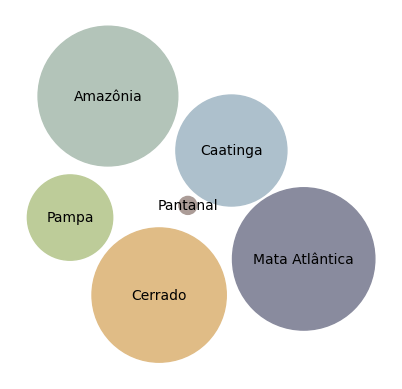

In [61]:

bubble_chart = BubbleChart(area=biome_gdf_merged_bubble['count_2021'],
                           bubble_spacing=10)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, biome_gdf_merged_bubble['Bioma'], biome_gdf_merged_bubble['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
